### Imports 

We will use the standard data science and machine learning libraries in this project. 

In [27]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Imputing missing values and scaling values
from sklearn.preprocessing import Imputer, MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [28]:
# Read in data into dataframes 
train_features = pd.read_csv('data/training_features.csv')
test_features = pd.read_csv('data/testing_features.csv')
train_labels = pd.read_csv('data/training_labels.csv')
test_labels = pd.read_csv('data/testing_labels.csv')

# Display sizes of data
print('Training Feature Size: ', train_features.shape)
print('Testing Feature Size:  ', test_features.shape)
print('Training Labels Size:  ', train_labels.shape)
print('Testing Labels Size:   ', test_labels.shape)

Training Feature Size:  (127, 18)
Testing Feature Size:   (55, 18)
Training Labels Size:   (127, 1)
Testing Labels Size:    (55, 1)


In [29]:
train_features.head()

,mxPH,mnO2,Cl,NO3,NH4,oPO4,PO4,Chla,season_autumn,season_spring,season_summer,season_winter,size_large_,size_medium,size_small_,speed_high__,speed_low___,speed_medium
0,8.20,9.5,2.200,0.672,10.00000,3.800,6.200,0.800,0,0,1,0,1,0,0,0,0,1
1,8.06,8.3,38.902,3.678,627.27301,205.636,219.909,6.209,1,0,0,0,1,0,0,0,1,0
2,8.20,9.4,45.273,7.195,345.45499,144.000,287.000,9.882,0,0,0,1,0,1,0,0,0,1
3,7.30,9.9,16.000,4.820,101.66700,14.667,85.000,2.000,0,0,0,1,1,0,0,1,0,0
4,7.20,11.3,9.000,0.230,120.00000,12.000,19.000,0.500,0,1,0,0,0,0,1,1,0,0


Alternativaly, to remove all rows with missing values fromthe data frame:


In [30]:
# df_algae=df_algae.dropna()
# df_algae.index = range(len(df_algae)) # this will index the rows again. Without this, the indexes will remain the same (The rows won't shift up)


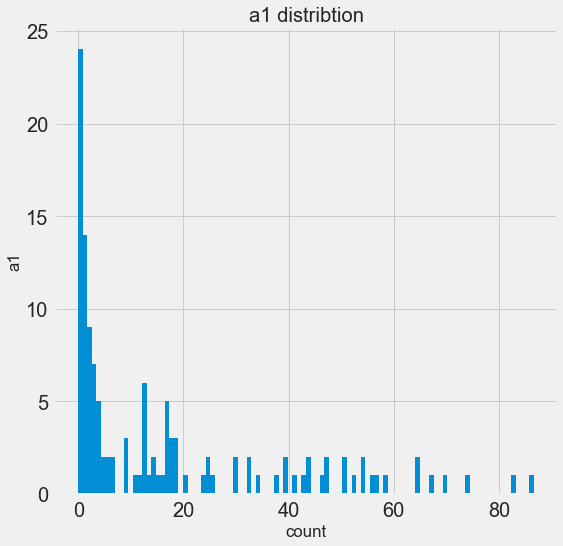

In [31]:
figsize(8, 8)

# Histogram of algae population a1
plt.style.use('fivethirtyeight')
plt.hist(train_labels['a1'].dropna(), bins = 100);
plt.xlabel('count'); plt.ylabel('a1'); 
plt.title('a1 distribtion');

### Evaluating and Comparing Machine Learning Models

In this section we will build, train, and evalute several machine learning methods for our supervised regression task. The objective is to determine which model holds the most promise for further development (such as hyperparameter tuning). 

We are comparing models using the __mean absolute error__. 

### Imputing Missing Values
Standard machine learning models cannot deal with missing values, and which means we have to find a way to fill these in or disard any features with missing values. 

We create a [Scikit-learn `Imputer` object](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to fill in missing values with the median of the column. 

Notice that we train the imputer (using the `Imputer.fit` method) on the training data but not the testing data. 

We then transform (using `Imputer.transform`) both the training data and testing data. 

This means that the missing values in the testing set are filled in with the median value of the corresponding columns in the training set. 

In [32]:
# Create an imputer object with a median filling strategy
imputer = Imputer(strategy='median')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

print('Missing values in training features: ', np.sum(np.isnan(X)))
print('Missing values in testing features:  ', np.sum(np.isnan(X_test)))

Missing values in training features:  0
Missing values in testing features:   0


In [33]:
# Make sure all values are finite
print(np.where(~np.isfinite(X)))
print(np.where(~np.isfinite(X_test)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


### Scaling Features

The final step to take before we can build our models is to [scale the features](https://en.wikipedia.org/wiki/Feature_scaling). This is necessary because features are in different units, and we want to normalize the features so the units do not affect the algorithm.

[Linear Regression and Random Forest do not require feature scaling](https://stats.stackexchange.com/questions/121886/when-should-i-apply-feature-scaling-for-my-data), but other methods, such as support vector machines and k nearest neighbors, do require it because they take into account the Euclidean distance between observations. For this reason, it is a best practice to scale features when we are comparing multiple algorithms. 

There are two ways to [scale features](http://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html):

1. For each value, subtract the mean of the feature and divide by the standard deviation of the feature. This is known as standardization and results in each feature having a mean of 0 and a standard deviation of 1.
2. For each value, subtract the minimum value of the feature and divide by the maximum minus the minimum for the feature (the range). This assures that all the values for a feature are between 0 and 1 and is called scaling to a range or normalization.

Here is a good article about [normalization and standardization](https://machinelearningmastery.com/normalize-standardize-machine-learning-data-weka/).

As with imputation, when we train the scaling object, we want to use only the training set. When we transform features, we will transform both the training set and the testing set.

In [34]:
# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
scaler.fit(X)

# Transform both the training and testing data
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [35]:
# Convert y to one-dimensional array (vector)
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))
print(y.shape)

(127,)


In [39]:
print(type(X))
print(type(X_test))
print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)
print(type(train_features))
print(type(test_features))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(127, 18)
(55, 18)
(127,)
(55,)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


## Models to Evaluate

We will compare five different machine learning models using the great [Scikit-Learn library](http://scikit-learn.org/stable/):

1. Linear Regression
2. Support Vector Machine Regression
3. Random Forest Regression
4. Gradient Boosting Regression
5. K-Nearest Neighbors Regression

At first, we just want to determine the baseline performance of each model, and then we can select the best performing model for further optimization using hyperparameter tuning.

Here we will implement the entire training and testing procedures for a number of models (in just a few lines of code).

In [24]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X, y)
    
    # Make predictions and evalute
    # check the model correctly predicts the test data
    Y_pred_train = model.predict(X)
    Y_mae_train = mae(y, Y_pred_train)

    # predict the real data
    Y_pred_test = model.predict(X_test)   
    Y_mae_test = mae(y_test, Y_pred_test)
    
    # fit and predict can be done in s single step
    # Y_pred_train = svr_rbf.fit(X, y).predict(X) 
    # Y_pred_test = svr_rbf.fit(X,y).predict(X_test) 

    
    # Return the performance metric
    return Y_pred_train, Y_mae_train, Y_pred_test, Y_mae_test

In [25]:
lr = LinearRegression()
lr_pred_train, lr_mae_train, lr_pred_test, lr_mae_test = fit_and_evaluate(lr)
print(f"Linear Regression Performance : train set : MAE = {lr_mae_train}, test set : MAE = { lr_mae_test}")

Linear Regression Performance : train set : MAE = 12.30763056110536, test set : MAE = 13.926775932064173


In [40]:
lr = SVR()
lr_pred_train, lr_mae_train, lr_pred_test, lr_mae_test = fit_and_evaluate(lr)
print(f"SVR Performance : train set : MAE = {lr_mae_train}, test set : MAE = { lr_mae_test}")

SVR Performance : train set : MAE = 14.132037462212798, test set : MAE = 16.07044845543413
